In [ ]:
# Pronóstico de Series de Tiempo

# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


In [ ]:
url = 'https://raw.githubusercontent.com/Abel-Lemus/Computacional-1-/main/Actividad6/26061.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251'
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha','Precip','Evap','Tmax','Tmin',]
df_Navojoa = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python') 

# Hacemos una copia de trabajo y preservamos el dataframe original
df_NAV = df_Navojoa.copy()

# Cambiamos la palabra nulo por un vacío y verificamos
str_Nulo = 'Nulo'
df_Nvojoa = df_NAV.replace(to_replace=str_Nulo, value='', regex=True)

# Convertimos los valores de las variables ambientales a números flotantes y verificamos 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_Nvojoa[cols] = pd.to_numeric(df_NAV[cols], errors='coerce')

# Definimos un nuevo dataframe por si hay que regresarse
df_new = df_Nvojoa.copy()
df_new['Fecha'].head()

# Se convierte el objeto Fecha a variable fecha que python reconoce
df_new['Fecha'] = pd.to_datetime(df_new['Fecha'], dayfirst=True).copy()

# Añadimos dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_new['Año'] = df_new['Fecha'].dt.year
df_new['Mes'] = df_new['Fecha'].dt.month

# Hacemos una copia del trabajo y es con el que trabajaremos para el análisis de datos
df_met = df_new.copy()

# Eliminamos la columna de Mes(numérico) y agregamos Mes(caractéres)
df_met.drop('Mes', axis=1, inplace=True)
df_met['Mes'] = df_met['Fecha'].dt.strftime('%b')

# Nueva copia del DataFrame para Series de Tiempo
df_met_ts = df_met.copy()

# Reemplazamos el índice por la variable 'Fecha' 
df_met_ts = df_met.set_index('Fecha')
df_met_ts.info()

# Seleccionaremos un conjunto de años de 30 años
df_60 = df_met_ts[(df_met_ts['Año'] >= 1922) & (df_met_ts['Año'] < 1953)]
df_70 = df_met_ts[(df_met_ts['Año'] >= 1953) & (df_met_ts['Año'] < 1985)]
df_90 = df_met_ts[(df_met_ts['Año'] >= 1985) & (df_met_ts['Año'] < 2016)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25775 entries, 1922-01-01 to 2016-04-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  25739 non-null  float64
 1   Evap    19131 non-null  float64
 2   Tmax    24841 non-null  float64
 3   Tmin    24837 non-null  float64
 4   Año     25775 non-null  int64  
 5   Mes     25775 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='darkorange',label='Original')
    plt.plot(rolmean, color='darkgreen', label='Rolling Mean')
    plt.plot(rolstd, color='rebeccapurple', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

**1.- Estacionaridad**

In [ ]:

#Empezamos el analisis haciendo una primera serie de tiempo para analizar, la cual corresponde a la epoca de 1953 a 1985

#Fechas de inicio y fin, para filtrar la informacion.
start, end = '1957-09','1963-09'

ts_70=df_70.loc[start:end].copy()
ts_70.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1960-02-04,0.0,NaN,24.3,NaN,1960,Feb
1960-02-05,0.0,NaN,27.5,6.9,1960,Feb
1960-02-06,0.0,NaN,26.8,8.1,1960,Feb
1960-02-07,0.0,NaN,26.7,9.0,1960,Feb
1960-02-08,0.0,NaN,27.5,9.8,1960,Feb


In [ ]:
# Vemos su encabezado
ts_70['Tmax'].head()

Fecha
1960-02-04    24.3
1960-02-05    27.5
1960-02-06    26.8
1960-02-07    26.7
1960-02-08    27.5
Name: Tmax, dtype: float64

In [ ]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico
ts_test_TMX = ts_70['Tmax'].copy()

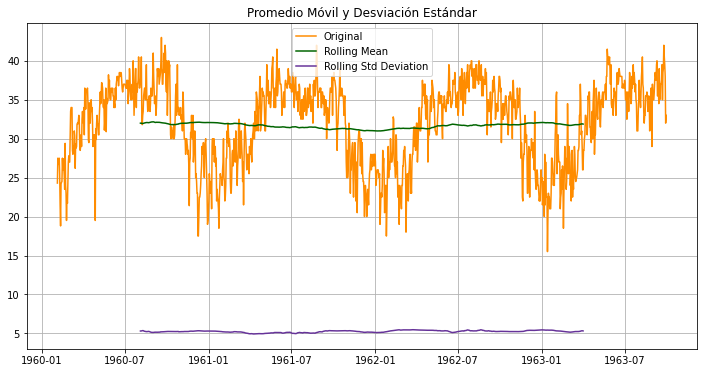

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.849416
p-value                           0.051554
#Lags Used                       14.000000
Number of Observations Used    1320.000000
Critical Value (1%)              -3.435314
Critical Value (5%)              -2.863732
Critical Value (10%)             -2.567937
dtype: float64


In [ ]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test_TMX)

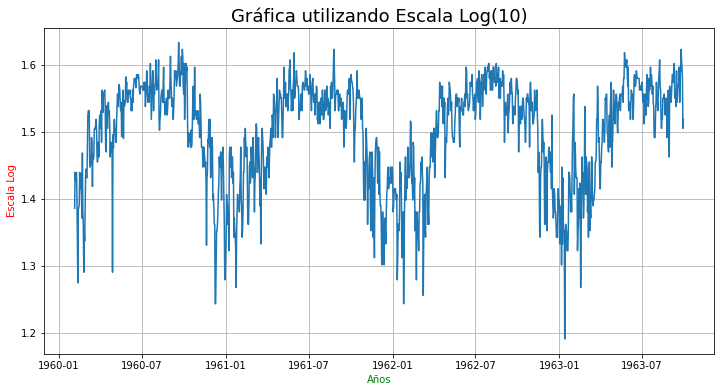

In [ ]:

# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMX_log = np.log10(ts_test_TMX)
plt.plot(ts_test_TMX_log)
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='r')
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

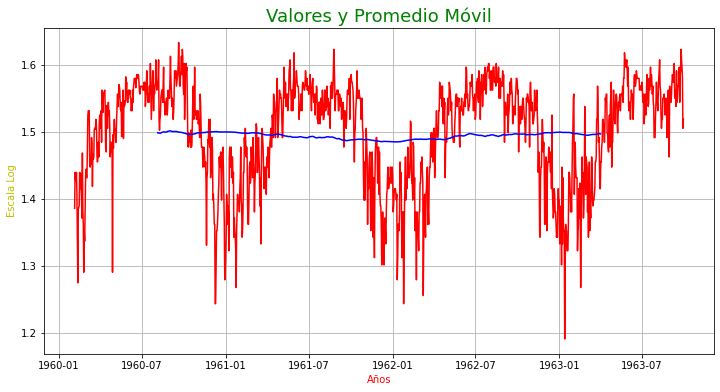

In [ ]:
moving_avg_TMX = ts_test_TMX_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMX_log,color = 'r' )
plt.plot(moving_avg_TMX, color = 'b')
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='y')
plt.title('Valores y Promedio Móvil', color ='g',size=18)
plt.grid()
plt.show();


In [ ]:
ts_test_log_moving_ave_diff_TMX = ts_test_TMX_log - moving_avg_TMX 
ts_test_log_moving_ave_diff_TMX.head()

Fecha
1960-02-04   NaN
1960-02-05   NaN
1960-02-06   NaN
1960-02-07   NaN
1960-02-08   NaN
Name: Tmax, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff_TMX.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMX.head()

Fecha
1960-08-04    0.069721
1960-08-05    0.081269
1960-08-06    0.109078
1960-08-07    0.020372
1960-08-08    0.004489
Name: Tmax, dtype: float64

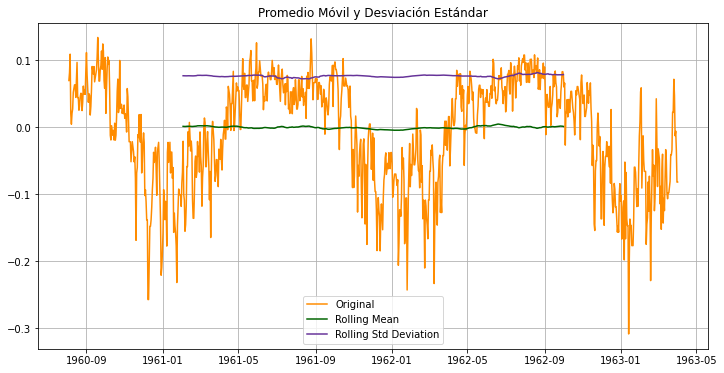

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.041186
p-value                          0.268811
#Lags Used                      19.000000
Number of Observations Used    951.000000
Critical Value (1%)             -3.437245
Critical Value (5%)             -2.864584
Critical Value (10%)            -2.568391
dtype: float64


In [ ]:
# Vamos a probar ahora la parte de la estacionaridad de una nueva serie de tiempo en una escala logaritmica 
test_stationarity(ts_test_log_moving_ave_diff_TMX)

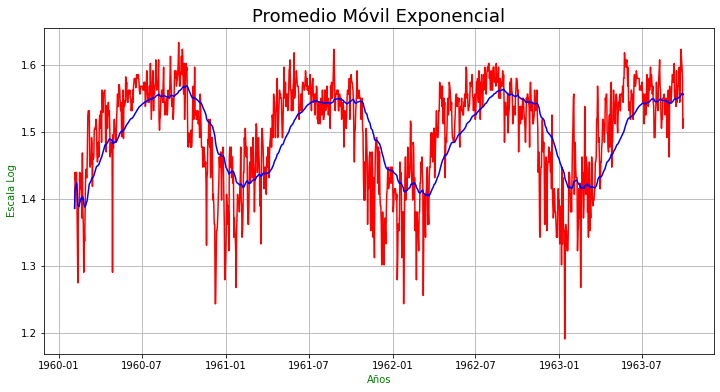

Fecha
1960-02-04    1.385606
1960-02-05    1.412780
1960-02-06    1.418017
1960-02-07    1.420215
1960-02-08    1.424217
Name: Tmax, dtype: float64

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
 
EWM_avg_TMX = ts_test_TMX_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMX_log, color = 'r')
plt.plot(EWM_avg_TMX, color = 'b')
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='g')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

EWM_avg_TMX.head()

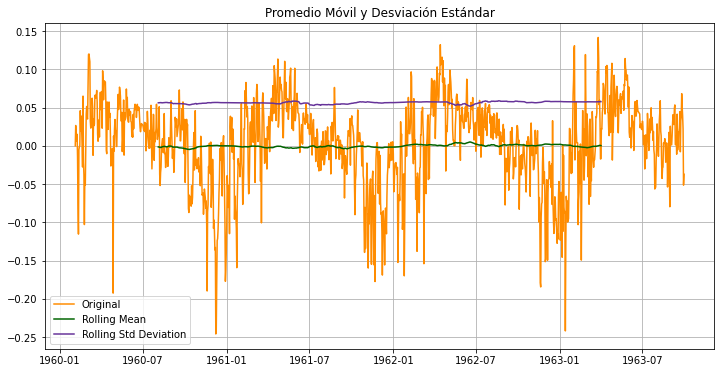

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.347403
p-value                           0.012888
#Lags Used                       19.000000
Number of Observations Used    1315.000000
Critical Value (1%)              -3.435333
Critical Value (5%)              -2.863740
Critical Value (10%)             -2.567942
dtype: float64


In [ ]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMX = ts_test_TMX_log - EWM_avg_TMX


# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMX)

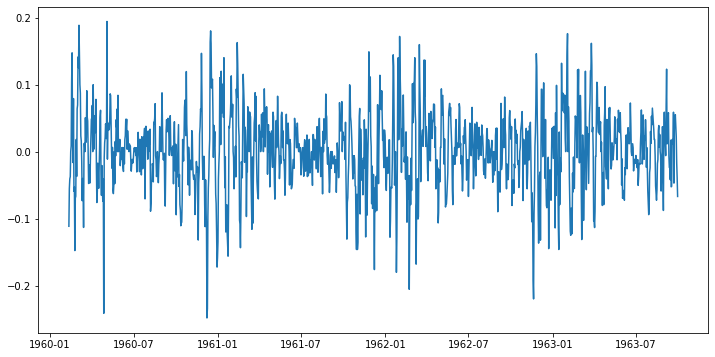

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMX = ts_test_TMX_log - ts_test_TMX_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMX);


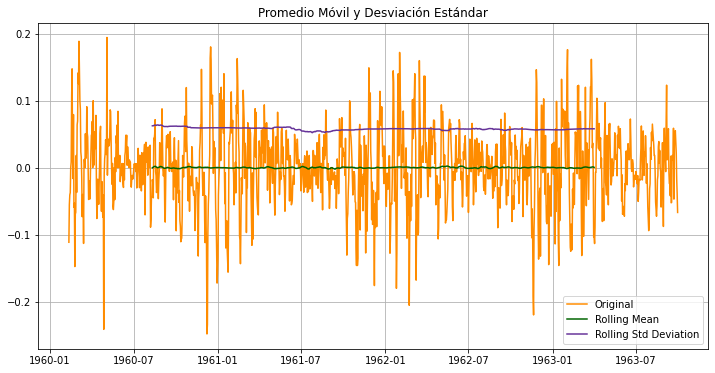

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.796245e+00
p-value                        2.172528e-14
#Lags Used                     2.100000e+01
Number of Observations Used    1.306000e+03
Critical Value (1%)           -3.435367e+00
Critical Value (5%)           -2.863756e+00
Critical Value (10%)          -2.567950e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMX)

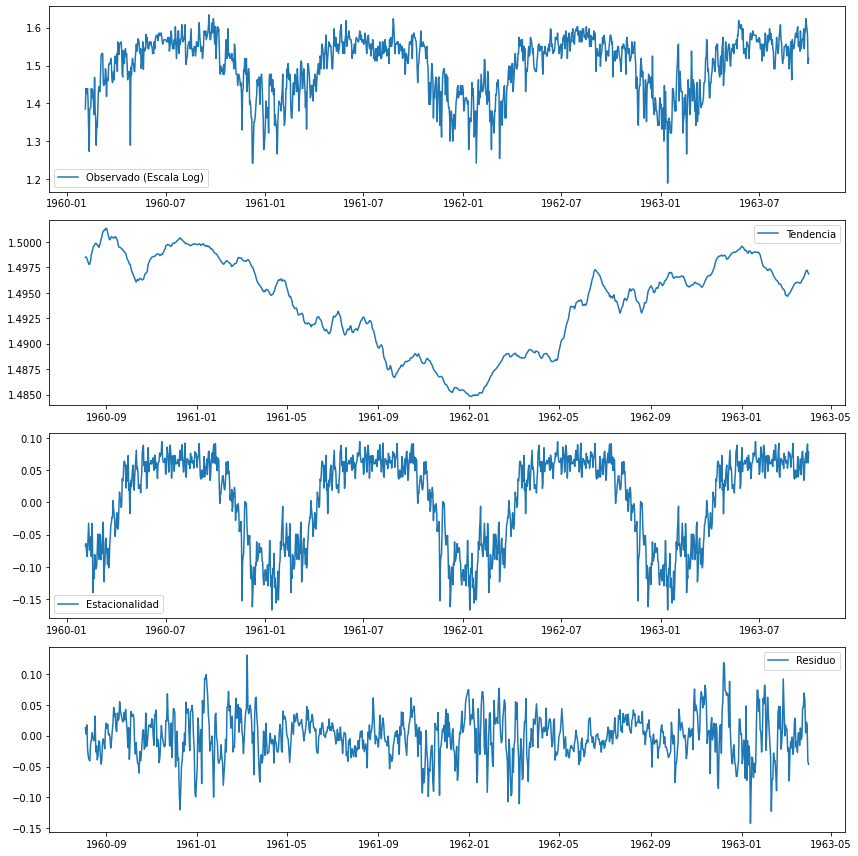

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMX = sm.tsa.seasonal_decompose(ts_test_TMX_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMX = decomposition_TMX.trend
seasonal_TMX = decomposition_TMX.seasonal
residue_TMX = decomposition_TMX.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMX_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMX, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMX, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMX, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

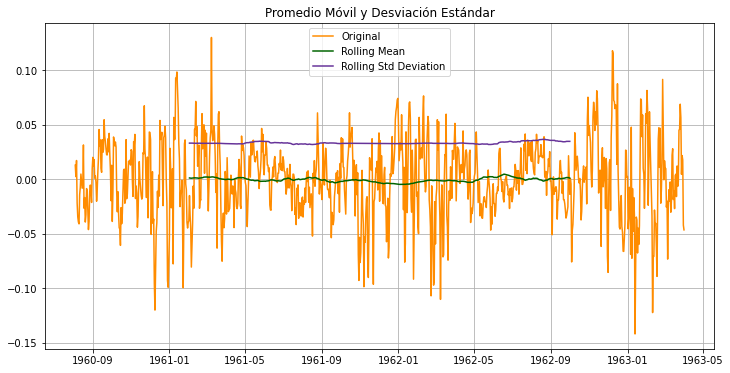

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.425861e+01
p-value                        1.439511e-26
#Lags Used                     0.000000e+00
Number of Observations Used    9.700000e+02
Critical Value (1%)           -3.437109e+00
Critical Value (5%)           -2.864524e+00
Critical Value (10%)          -2.568359e+00
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMX = residue_TMX 
ts_test_log_decompose_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMX)

Text(0.5, 1.0, 'Partial Autocorrelation Function (Ubica el valor de p)')

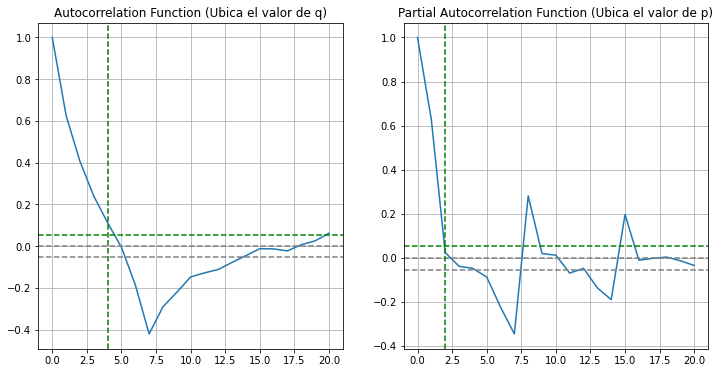

In [ ]:

# Aplicamos ARIMA

lag_acf_TMX = acf(ts_test_log_diff_TMX, nlags=20)
lag_pacf_TMX = pacf(ts_test_log_diff_TMX, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1334
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2614.328
Method:                       css-mle   S.D. of innovations              0.034
Date:                Fri, 12 Mar 2021   AIC                          -5220.656
Time:                        07:38:44   BIC                          -5199.872
Sample:                    02-05-1960   HQIC                         -5212.867
                         - 09-30-1963                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.229e-05      0.001      0.137      0.891      -0.001       0.001
ar.L1.D.Tmax    -0.2424      0.027     -8.937      0.000      -0.296      -0.189
ar.L2.D.Tmax    -0.1406      0.027     -5.17

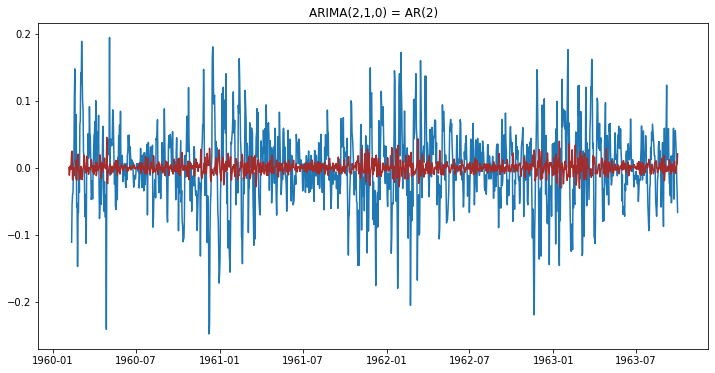

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,0), missing='drop')
results_AR_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_AR_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMX.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1334
Model:                 ARIMA(0, 1, 5)   Log Likelihood                2659.743
Method:                       css-mle   S.D. of innovations              0.033
Date:                Fri, 12 Mar 2021   AIC                          -5305.486
Time:                        07:39:39   BIC                          -5269.114
Sample:                    02-05-1960   HQIC                         -5291.856
                         - 09-30-1963                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.494      0.621      -0.000       0.001
ma.L1.D.Tmax    -0.3205      0.027    -11.717      0.000      -0.374      -0.267
ma.L2.D.Tmax    -0.1592      0.029     -5.56

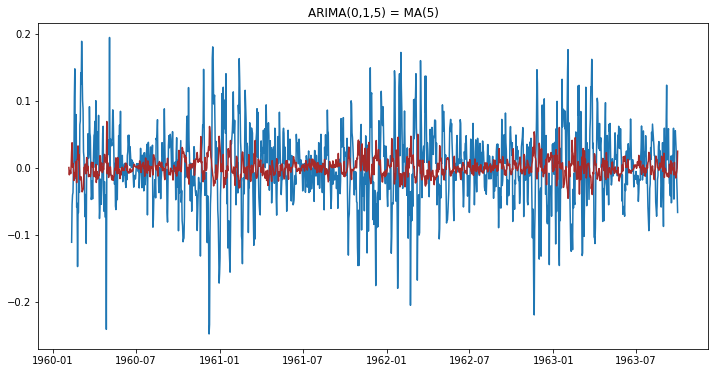

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(0,1,5), missing='drop')
results_MA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_MA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMX.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1334
Model:                 ARIMA(2, 1, 5)   Log Likelihood                2662.212
Method:                       css-mle   S.D. of innovations              0.033
Date:                Fri, 12 Mar 2021   AIC                          -5306.423
Time:                        07:40:21   BIC                          -5259.660
Sample:                    02-05-1960   HQIC                         -5288.900
                         - 09-30-1963                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.524      0.600      -0.000       0.001
ar.L1.D.Tmax     0.1342      0.420      0.320      0.749      -0.689       0.957
ar.L2.D.Tmax     0.3768      0.257      1.46

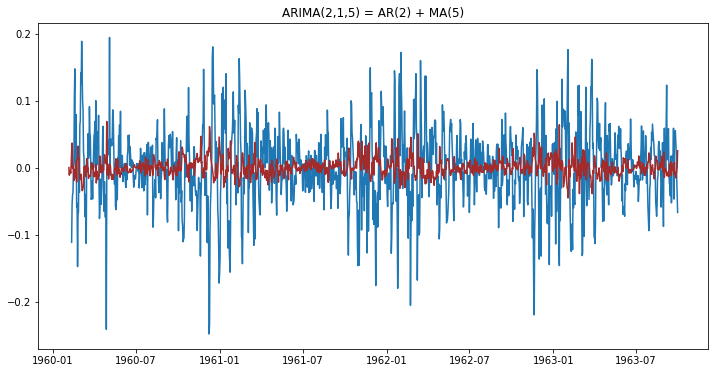

In [ ]:

# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,5), missing='drop')
results_ARIMA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_ARIMA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMX.summary());

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMX = pd.Series(results_ARIMA_TMX.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMX)

Fecha
1960-02-05    0.000118
1960-02-06   -0.011233
1960-02-07   -0.004629
1960-02-08   -0.004468
1960-02-09   -0.008372
                ...   
1963-09-26   -0.015492
1963-09-27   -0.010791
1963-09-28   -0.004673
1963-09-29   -0.000446
1963-09-30    0.025169
Length: 1334, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMX = pd.Series(ts_test_TMX_log, index = ts_test_TMX_log.index)
predictions_ARIMA_log_TMX = predictions_ARIMA_log_TMX.add(predictions_ARIMA_diff_TMX)
print(predictions_ARIMA_log_TMX.head())
print(predictions_ARIMA_log_TMX.tail())

Fecha
1960-02-04         NaN
1960-02-05    1.439451
1960-02-06    1.416902
1960-02-07    1.421882
1960-02-08    1.434865
dtype: float64
Fecha
1963-09-26    1.591963
1963-09-27    1.585806
1963-09-28    1.575110
1963-09-29    1.504704
1963-09-30    1.543683
dtype: float64


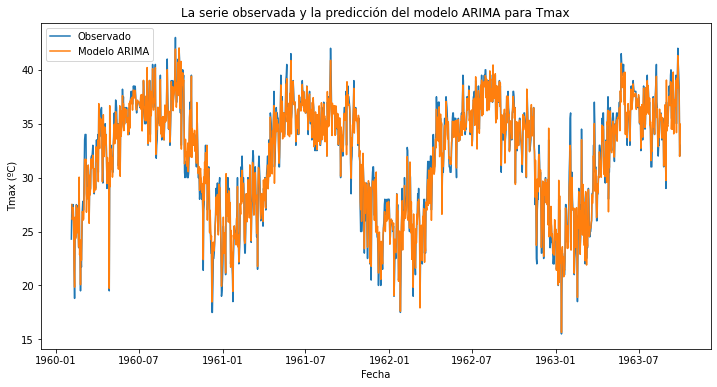

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMX = 10**(predictions_ARIMA_log_TMX)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMX, label='Observado');
plt.plot(predictions_ARIMA_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMX = np.sqrt(np.mean((predictions_ARIMA_TMX - ts_test_TMX)**2))
print('RMSE:', RMSE_TMX)

RMSE: 0.8488360187311096


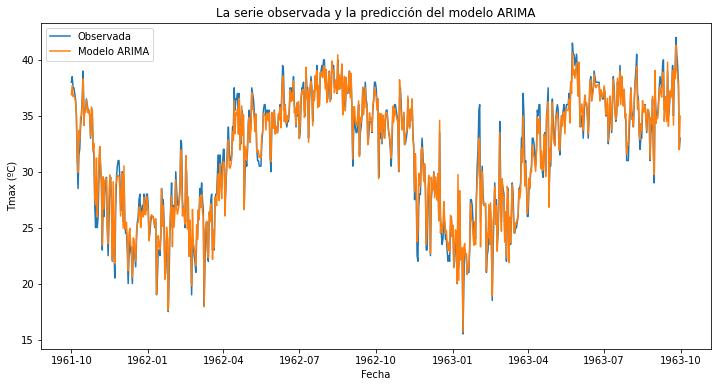

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMX = ts_test_TMX.tail(730)
predictions_ARIMA_last_TMX = predictions_ARIMA_TMX.tail(730)
plt.plot(ts_test_last_TMX, label='Observada');
plt.plot(predictions_ARIMA_last_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

**Repetiremos el mismo procedimiento, pero ahora, con la temperatura minima **

In [ ]:
# Definimos para la temperatura minima 
ts_70['Tmin'] = df_70['Tmin'] 
ts_70.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1960-02-04,0.0,NaN,24.3,NaN,1960,Feb
1960-02-05,0.0,NaN,27.5,6.9,1960,Feb
1960-02-06,0.0,NaN,26.8,8.1,1960,Feb
1960-02-07,0.0,NaN,26.7,9.0,1960,Feb
1960-02-08,0.0,NaN,27.5,9.8,1960,Feb


In [ ]:
# Vemos su encabezado
ts_70['Tmin'].head()

Fecha
1960-02-04    NaN
1960-02-05    6.9
1960-02-06    8.1
1960-02-07    9.0
1960-02-08    9.8
Name: Tmin, dtype: float64

In [ ]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar
ts_test_TMN = ts_70['Tmin'].copy()


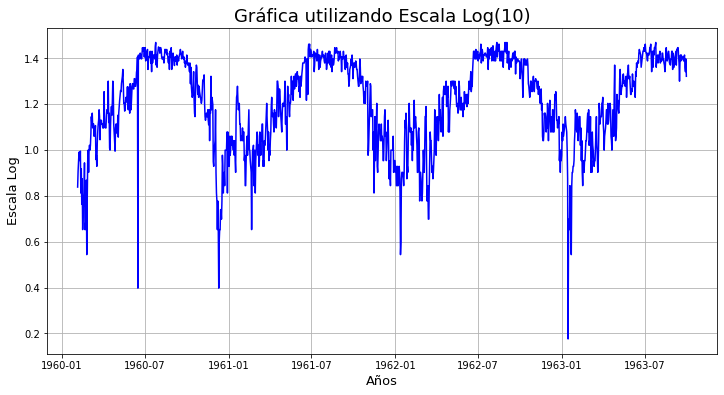

In [ ]:

# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMN_log = np.log10(ts_test_TMN)
plt.plot(ts_test_TMN_log, color='blue')
plt.xlabel('Años',size=13)
plt.ylabel('Escala Log',size=13)
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

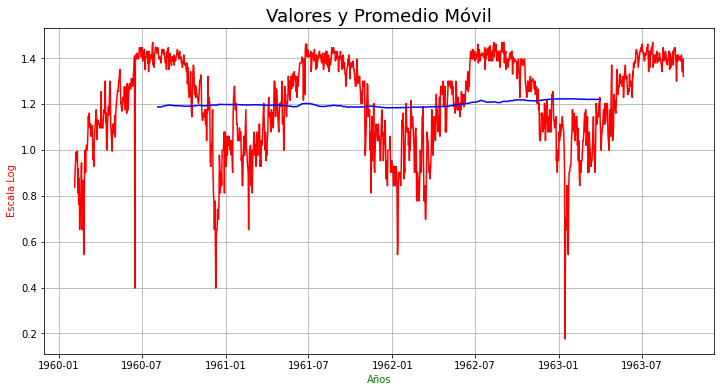

In [ ]:
moving_avg_TMN = ts_test_TMN_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMN_log, color = 'r')
plt.plot(moving_avg_TMN, color = 'b')
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='r')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [ ]:
ts_test_log_moving_ave_diff_TMN = ts_test_TMN_log - moving_avg_TMN 
ts_test_log_moving_ave_diff_TMN.head()

Fecha
1960-02-04   NaN
1960-02-05   NaN
1960-02-06   NaN
1960-02-07   NaN
1960-02-08   NaN
Name: Tmin, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff_TMN.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMN.head()

Fecha
1960-08-05    0.258844
1960-08-06    0.250702
1960-08-07    0.217720
1960-08-08    0.209419
1960-08-09    0.209819
Name: Tmin, dtype: float64

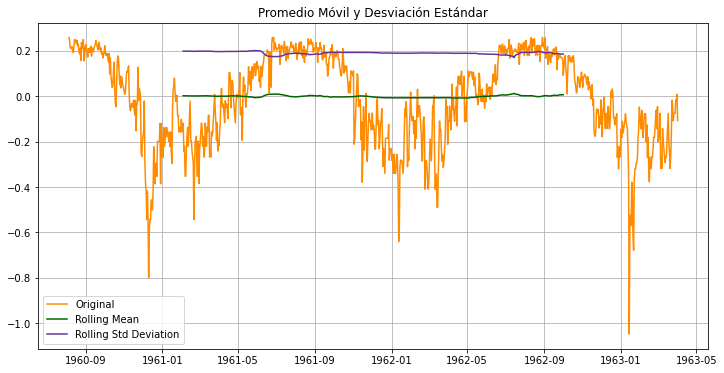

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -3.211051
p-value                          0.019354
#Lags Used                       5.000000
Number of Observations Used    964.000000
Critical Value (1%)             -3.437152
Critical Value (5%)             -2.864543
Critical Value (10%)            -2.568369
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMN)

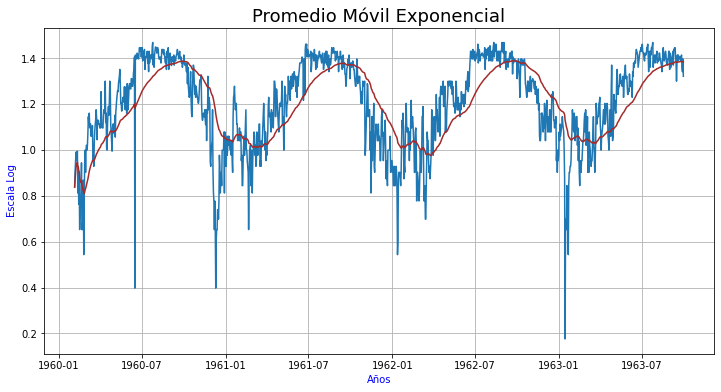

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMN = ts_test_TMN_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMN_log)
plt.plot(EWM_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [ ]:
EWM_avg_TMX.head()

Fecha
1960-02-04    1.385606
1960-02-05    1.412780
1960-02-06    1.418017
1960-02-07    1.420215
1960-02-08    1.424217
Name: Tmax, dtype: float64

In [ ]:

# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMN = ts_test_TMN_log - EWM_avg_TMN

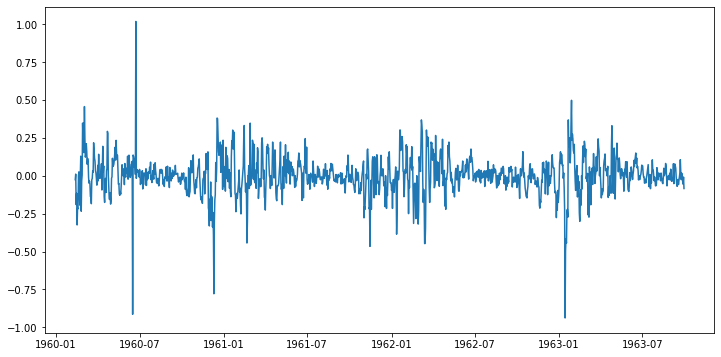

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMN = ts_test_TMN_log - ts_test_TMN_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMN);

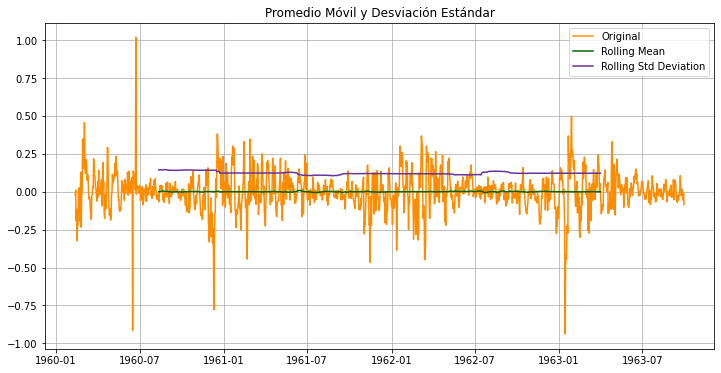

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.990729e+00
p-value                        2.478603e-12
#Lags Used                     2.100000e+01
Number of Observations Used    1.305000e+03
Critical Value (1%)           -3.435371e+00
Critical Value (5%)           -2.863757e+00
Critical Value (10%)          -2.567950e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMN)

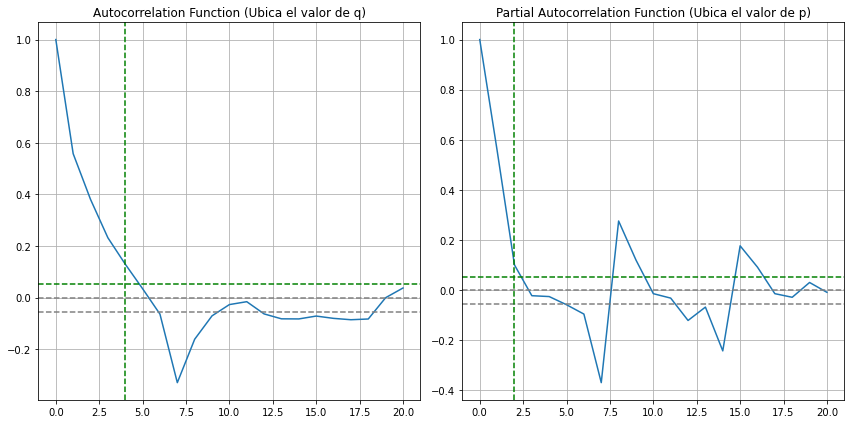

In [ ]:
# Aplicamos ARIMA

lag_acf_TMN = acf(ts_test_log_diff_TMN, nlags=20)
lag_pacf_TMN = pacf(ts_test_log_diff_TMN, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1333
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1515.457
Method:                       css-mle   S.D. of innovations              0.078
Date:                Fri, 12 Mar 2021   AIC                          -3022.914
Time:                        08:08:05   BIC                          -3002.133
Sample:                    02-06-1960   HQIC                         -3015.127
                         - 09-30-1963                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0004      0.001      0.250      0.803      -0.002       0.003
ar.L1.D.Tmin    -0.3471      0.027    -12.795      0.000      -0.400      -0.294
ar.L2.D.Tmin    -0.1401      0.027     -5.16

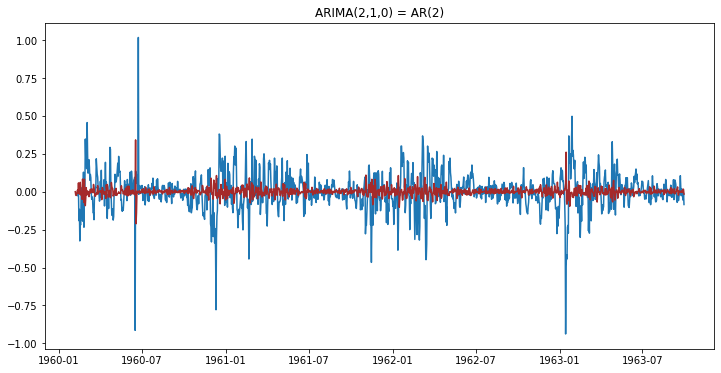

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,0), missing='drop')
results_AR_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_AR_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMN.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1333
Model:                 ARIMA(2, 1, 5)   Log Likelihood                1554.636
Method:                       css-mle   S.D. of innovations              0.075
Date:                Fri, 12 Mar 2021   AIC                          -3091.272
Time:                        08:10:37   BIC                          -3044.515
Sample:                    02-06-1960   HQIC                         -3073.750
                         - 09-30-1963                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0004      0.001      0.460      0.646      -0.001       0.002
ar.L1.D.Tmin    -0.0639      0.008     -8.123      0.000      -0.079      -0.048
ar.L2.D.Tmin    -0.9781      0.006   -154.14

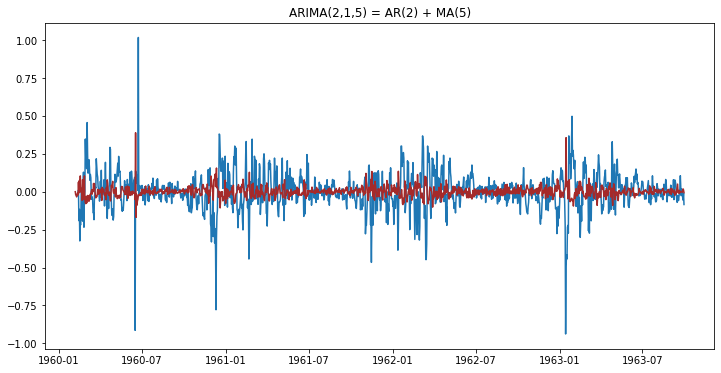

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,5), missing='drop')
results_ARIMA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_ARIMA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMN.summary());

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMN = pd.Series(results_ARIMA_TMN.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMN)

Fecha
1960-02-06    0.000354
1960-02-07   -0.020651
1960-02-08   -0.025379
1960-02-09   -0.034080
1960-02-10   -0.020630
                ...   
1963-09-26   -0.003855
1963-09-27    0.003228
1963-09-28    0.018774
1963-09-29    0.011651
1963-09-30   -0.005946
Length: 1333, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMN = pd.Series(ts_test_TMN_log, index = ts_test_TMN_log.index)
predictions_ARIMA_log_TMN = predictions_ARIMA_log_TMN.add(predictions_ARIMA_diff_TMN)
print(predictions_ARIMA_log_TMN.head())
print(predictions_ARIMA_log_TMN.tail())

Fecha
1960-02-04         NaN
1960-02-05         NaN
1960-02-06    0.908839
1960-02-07    0.933591
1960-02-08    0.965847
dtype: float64
Fecha
1963-09-26    1.411119
1963-09-27    1.364955
1963-09-28    1.361197
1963-09-29    1.409591
1963-09-30    1.316273
dtype: float64


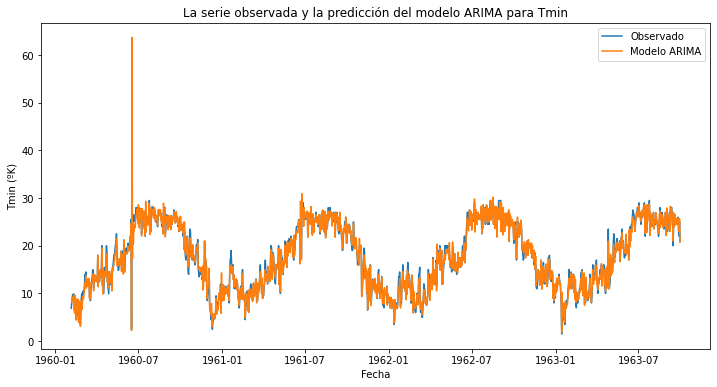

In [ ]:

# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMN = 10**(predictions_ARIMA_log_TMN)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMN, label='Observado');
plt.plot(predictions_ARIMA_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºK)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [ ]:
print(predictions_ARIMA_TMN)

Fecha
1960-02-04          NaN
1960-02-05          NaN
1960-02-06     8.106611
1960-02-07     8.582054
1960-02-08     9.243719
                ...    
1963-09-26    25.770254
1963-09-27    23.171570
1963-09-28    22.971884
1963-09-29    25.679781
1963-09-30    20.714432
Length: 1335, dtype: float64


In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMN = np.sqrt(np.mean((predictions_ARIMA_TMN - ts_test_TMN)**2))
print('RMSE:', RMSE_TMN)

RMSE: 1.4448845775673196


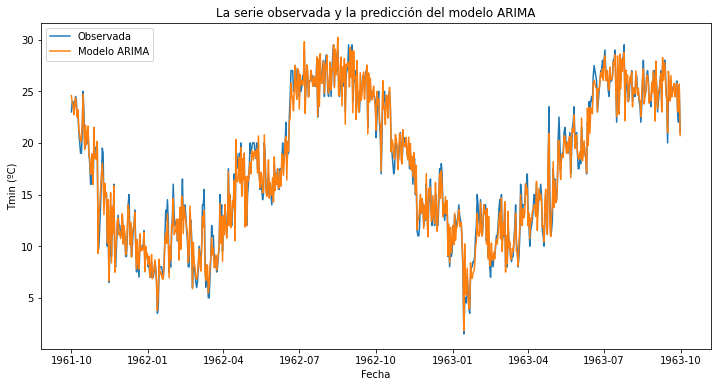

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMN_C = ts_test_TMN.tail(730)
predictions_ARIMA_last_TMN = predictions_ARIMA_TMN.tail(730)
plt.plot(ts_test_last_TMN_C, label='Observada');
plt.plot(predictions_ARIMA_last_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');